In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as ima
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
%matplotlib inline

/home/pedro/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# M87

M87 es una galaxia elíptica perteneciente al cúmulo de Virgo ubicada a una distancia aproximada de 16 Mpc, tiene la característica de ser una galaxia activa y destaca un jet de materia que proviene de su nucleo.

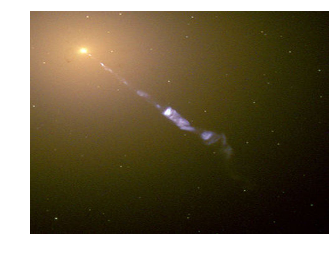

In [2]:
img = ima.imread('./slide_2.jpg')
plt.axis('off')
plt.imshow(img)

In [3]:
hd1 = fits.open('hst_9401_02_acs_wfc_f850lp_drz.fits') #archivos que se extrajeron de la web
hd2 = fits.open('hst_9401_02_acs_wfc_f475w_drz.fits')

ext1 = hd1[1]
ext2 = hd2[1]

ext1.writeto('sci_f850lp_M87.fits', clobber = True) #se extraen las imagenes de ciencia
ext2.writeto('sci_f475w_M87.fits', clobber = True)

ext1 = hd1[2]
ext2 = hd2[2]

ext1.writeto('invvar_f850lp_M87.fits', clobber = True) #se extraen los errores de la imagenes
ext2.writeto('invvar_f475w_M87.fits', clobber = True)

hd1.close()
hd2.close()

A continuación se muestran las imganes de M87 en los filtros F475W y F850LP tomadas por el Telescopio Espacial Hubble

/home/pedro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/home/pedro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/home/pedro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/home/pedro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10


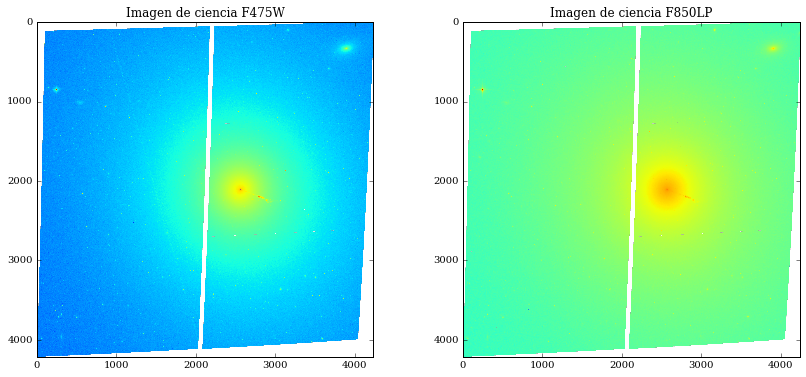

In [4]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title("Imagen de ciencia F475W")
hd1 = fits.open('sci_f475w_M87.fits')
dat = hd1[1].data
imgplot = plt.imshow(np.log10(dat),cmap="jet")

plt.subplot(1,2,2)
plt.title("Imagen de ciencia F850LP")
hd2 = fits.open('sci_f850lp_M87.fits')
dat = hd2[1].data
imgplot = plt.imshow(np.log10(dat),cmap='jet')

hd1.close()
hd2.close()

Luego se utiliza SExtractor con el objetivo de realizar una fotometría de apertura a cada imagen, lo escencial en este proceso es eliminar, de algún modo, el brillo de la galaxia para poder detectar fuentes puntuales.

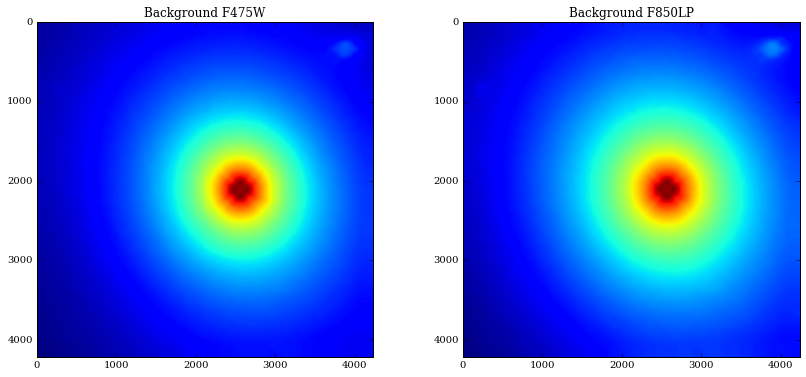

In [5]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title("Background F475W")
hd1 = fits.open('B1.fits')
dat = hd1[0].data
imgplot = plt.imshow(np.log10(dat),cmap="jet")

plt.subplot(1,2,2)
plt.title("Background F850LP")
hd2 = fits.open('B2.fits')
dat = hd2[0].data
imgplot = plt.imshow(np.log10(dat),cmap='jet')

hd1.close()
hd2.close()

Se extrae la galaxia en ambas imágenes, representadas arriba. Después se procede a realizar la fotometría a los objetos que resaltan una vez la influencia del brillo de la galaxia ha desaparecido, debido a que es una galaxia del tipo elíptica se puede asumir que los objetos detectados, en su mayoria, son cumulos globulares. Luego se produjeron los catálogos para ambos filtros y se calibra en magnitudes según el sistema fotométrico VEGAMAG

In [6]:
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii   

#----------------------f475-------------------------------
fil = open("./f475.cat","r") 
body = ascii.read(fil)

RA1 = np.array(body["ALPHA_J2000"])
DEC1 = np.array(body["DELTA_J2000"])
MAG1 = np.array(body["MAG_APER"]) + 26.168 - 0.454 - 0.076  # Mag_source + Mag_zp - Mag_ap - Mag_rd
MAG_ERR1 = np.array(body["MAGERR_APER"])

fil.close()

#----------------------f850-------------------------------
fil = open("./f850.cat","r") 
body = ascii.read(fil)

RA2 = np.array(body["ALPHA_J2000"])
DEC2 = np.array(body["DELTA_J2000"])
MAG2 = np.array(body["MAG_APER"]) + 24.326 - 0.687 - 0.029 # Mag_source + Mag_zp - Mag_ap - Mag_rd
MAG_ERR2 = np.array(body["MAGERR_APER"])

fil.close()

Luego se realiza un match entre los catálogos y se seleccionan todas esas fuentes que posean una razón de señal a ruido mayor a 20

In [7]:
c = SkyCoord(ra=RA2*u.degree, dec=DEC2*u.degree)  
catalog = SkyCoord(ra=RA1*u.degree, dec=DEC1*u.degree)  
idx, d2d, d3d = match_coordinates_sky(c, catalog)

MAG_COLOR = []
MAG_G = []
MAG_Z = []

for i in range(0,len(RA2)):
    if MAG1[idx[i]]/MAG_ERR1[idx[i]] > 20 and MAG2[i]/MAG_ERR2[i] > 20:
        G_o = MAG1[idx[i]]
        Z_o = MAG2[i]
        G = G_o
        Z = Z_o
        color = G-Z
        MAG_COLOR.append(color)
        MAG_G.append(G)
        MAG_Z.append(Z)


Finalmente se crea un histograma de color de las bandas *g* y *z*

Total de cúmulos emparejados = 1445


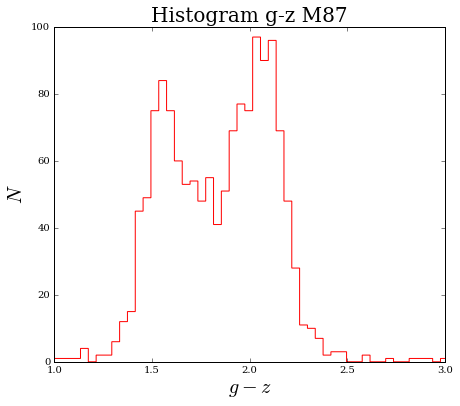

In [8]:
plt.figure(figsize=(7,6))
plt.xlim(1,3)
plt.title("Histogram g-z M87",size=20)
plt.xlabel('$g-z$',size=20)
plt.ylabel('$N$',size=20)
n, bins, patch = plt.hist(MAG_COLOR,150, histtype='step', color='r')
print "Total de cúmulos emparejados =",len(MAG_COLOR)

En el histograma anterior se ve la existencia de dos peaks, esto significa la existencia de dos poblaciones diferentes de cúmulos globulares, esto es así debido a que según *Harris (1991)* una población de cúmulos globulares, su función luminosidad, puede ser descrita como una gausseana, luego el histograma obtenido representa la suma de dos gausseanas y por lo tanto de dos poblaciones. Además notar la cantidad de cúmlos que se han detectado, hay que tener en consideración que la cantidad de cúmulos globulares existentes en la Vía Láctea es de aproximadamente 150.

In [9]:
def rebin(bins):
    aux=[]
    i=0
    while i < len(bins)-1:
        aux.append((bins[i]+bins[i+1])/2.0)
        i+=1
    return np.array(aux)

A continuación se realiza un histograma solo de la magnitud *z* 

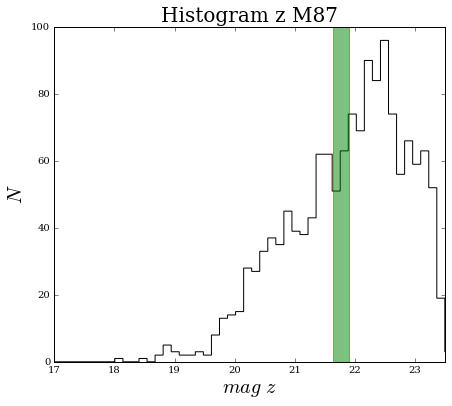

In [10]:
plt.figure(figsize=(7,6))
plt.title("Histogram z M87",size=20)
plt.xlim(17,23.5)
plt.xlabel('$mag\ z$',size=20)
plt.ylabel('$N$',size=20)
n, bins, patch = plt.hist(MAG_Z,70, histtype='step', color='k')
delta_bin = np.abs(bins[1]-bins[2])
plt.axvspan(xmin=21.77496509-delta_bin,xmax=21.77496509+delta_bin,color='g',alpha=0.5)
print " "

Como se ve en la figura anterior, la distribución posee un peak bien definido y se alcanza en la zona que esta marcada de verde, sin embargo, para tener un valor estimado se ajusta una curva a los puntos medios de las barras del histograma

El máximo se alcanza en la magnitud = 22.4922188889


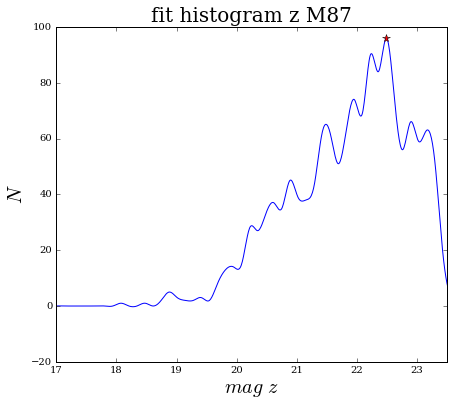

In [11]:
from scipy.interpolate import interp1d

a=rebin(bins)

ajuste = interp1d(a,n, kind='cubic')

new = np.linspace(np.min(a),np.max(a),1000)

plt.figure(figsize=(7,6))
plt.title("fit histogram z M87",size=20)
plt.xlim(17,23.5)
plt.xlabel('$mag\ z$',size=20)
plt.ylabel('$N$',size=20)

plt.xlim(17,23.5)
plt.plot(new,ajuste(new))

peak_N = new[np.where(np.max(ajuste(new))==ajuste(new))]
plt.plot(peak_N,np.max(ajuste(new)),'r*',ms=8)
print "El máximo se alcanza en la magnitud =",peak_N[0]

Luego tenemos la magnitud donde se alcanza el peak, sin embargo, debido al ancho de los bins habrá un error asociado, entonces se tiene $m_{z} = 21.774 \pm 0.264$. Con este valor es posible estimar la distancia a la que se encuentra el cúmulo y por consiguiente la galaxia contenedora, usando el método para estimar distancias del *Globular Cluster Luminosity Function* el cual señala que un cúmulo globular puede ser considerado como una candela estandart con magnitud absoluta $M_{z} = 9.75\pm 1.05$ (*Andrés Jordán 2006*) se puede estimar la distancia vía módulo de distancia y es $20.174\ Mpc$ y si se compara con el valor obtenido en *Mei et al. 2005, 2006* que es de $16.5\ Mpc$ se obtiene un error porcentual de $22.27\%$.

Nota: se debe señalar que la distancia obtenida puede no estar correcta debido a que no fue posible identificar el sistema fotométrico en el que está $M_{z}$ y puede o no corresponder a VEGAMAG.

Ahora compararemos la emisión en las bandas anteriormente mencionadas con una imágen en rayos X

/home/pedro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/home/pedro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


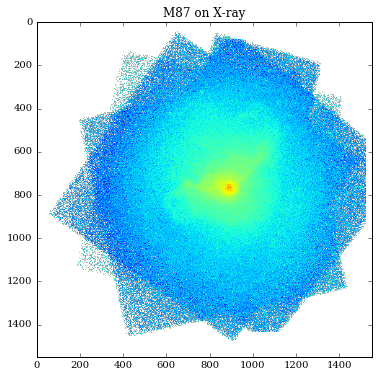

In [12]:
plt.figure(figsize=(14,6))

plt.title("M87 on X-ray")
hd1 = fits.open('m87_broadband.fits')
dat = hd1[0].data
imgplot = plt.imshow(np.log10(dat),cmap="jet")

hd1.close()

La imagen anterior fue tomada por el Telescopio Espacial Chandra y posee 500 ks de exposición aproximadamente, luego se realiza una detección con SExtractor para obtener el número de fuentes

In [13]:
#----------------------xray-------------------------------
fil = open("./xray.cat","r") 
body = ascii.read(fil)

RA3 = np.array(body["ALPHA_J2000"])
DEC3 = np.array(body["DELTA_J2000"])

fil.close()

In [14]:
c = SkyCoord(ra=RA3*u.degree, dec=DEC3*u.degree)  
catalog = SkyCoord(ra=RA2*u.degree, dec=DEC2*u.degree)  
idx, d2d, d3d = match_coordinates_sky(c, catalog)

aux = []
for element in d2d:
    if element.arcsec < 2.5: #seleccionar aquellos matches que tengan una distancia angular menor a 2.5''
        aux.append(element.arcsec)

print "El número de emparejamientos entre la imagen tomada con F850LP y en X-ray y además que es de:",len(aux)


El número de emparejamientos entre la imagen tomada con F850LP y en X-ray y además que es de: 5


In [15]:
c = SkyCoord(ra=RA3*u.degree, dec=DEC3*u.degree)  
catalog = SkyCoord(ra=RA1*u.degree, dec=DEC1*u.degree)  
idx, d2d, d3d = match_coordinates_sky(c, catalog)

aux = []
for element in d2d:
    if element.arcsec < 2.5:#seleccionar aquellos matches que tengan una distancia angular menor a 2.5''
        aux.append(element.arcsec)

print "El número de emparejamientos entre la imagen tomada con F475W y en X-ray es de:",len(aux)

El número de emparejamientos entre la imagen tomada con F475W y en X-ray es de: 3


Notar que hay algunas coincidencias entre las imagenes en *g* y *z* con la tomada en X-ray, esto se debe a que en os cúmulos existem sistemas binarios donde una de las estrellas es una estrella de neutrones, más común, o un agujero negro de masa intermedia, a esto se le denomina *Low-mass X-ray binary*. La estrella que está en secuencia principal (generalmente) ve acretada su masa hacia la estrella de neutrones y en el proceso de acreción es donde se emite rayos X, los procesos de acreción se encuentran entre los procesos más eficientes de generación de energía, superado en un orden de magnitud a la energía nuclear producida por fusión. En cúmulos globulares se da este fenómeno con mayor frecuencia debido a la alta densidad estelar presente, pues es fácil que exista un sistema binario.

# Jet superlumínico

Segun *J. A. Biretta, W. B. Sparks, & F. Macchetto 1999* la velocidad en la que se midieron los "nudos" del jet de M87 es de aproximadamente $6c$, esto no es nada más que una ilusión creada por la velocidad finita de la luz y el movimiento rápido. Ocurre cuando la nube se mueven hacia la Tierra a velocidades muy cercanas a la de la luz. A estas velocidades, las nubes casi siguen el ritmo de la luz que emiten a medida que avanzan hacia la Tierra, por lo que cuando la luz llega finalmente a nosotros, el movimiento parece mucho más rápido que la velocidad de la luz Dado que las nubes en movimiento viajan ligeramente más lentamente que la velocidad de la luz, por lo que no violan la teoría de la relatividad (extracto de John Biretta 1999). Esta luz que proviene de las nubes se genera, en general, por procesos no termales coo es el caso de la emisión por sinclotrón así como la emisión en radio frecuencias y rayos X (Eric S. Perlman et al 2000).
 